In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.api as sm

**Info about original data:**
- Original data = Headway Data, 8-1-2023 to 9-30-2023.xlsx
- Number of observations: 350,328 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 30 columns):
Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  datetime64[ns]
 4   ROUTE_ABBR                 350328 non-null  int64         
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64       
 12  TRIP_EDGE                  350328 non-null  int64         
 13  LATITUDE                   350328 non-null  float64       
 14  LONGITUDE                  350328 non-null  float64       
 15  SCHEDULED_TIME             350328 non-null  object        
 16  ACTUAL_ARRIVAL_TIME        338869 non-null  object        
 17  ACTUAL_DEPARTURE_TIME      338860 non-null  object        
 18  ADHERENCE                  338860 non-null  float64       
 19  SCHEDULED_HDWY             274737 non-null  float64       
 20  ACTUAL_HDWY                266061 non-null  float64       
 21  HDWY_DEV                   265892 non-null  float64       
 22  ADJUSTED_EARLY_COUNT       350328 non-null  int64         
 23  ADJUSTED_LATE_COUNT        350328 non-null  int64         
 24  ADJUSTED_ONTIME_COUNT      350328 non-null  int64         
 25  STOP_CANCELLED             350328 non-null  int64         
 26  PREV_SCHED_STOP_CANCELLED  279999 non-null  float64       
 27  IS_RELIEF                  350328 non-null  int64         
 28  BLOCK_STOP_ORDER           350328 non-null  int64         
 29  DWELL_IN_MINS              338857 non-null  float64 
 
- We removed null values because there were only 265,892 observations with existing HDWY_DEV columns. New dataframe -> headway_data, 265884 entries (75.89%)
- Also removed outliers from the HDWY_DEV and ADHERENCE columns. New dataframe -> processed_data, 254299 entries (72% of original data OR 95.64% of data after removing null values). 
- Data cleanup was based on keeping the 99.9th percentile of the data's HDWY_DEV and ADHERENCE z-scores. Dataset was grouped into each UNIQUE_TRIP_ID (this is the unique ID for each trip on a specific day; trip numbers were reused after a couple days). Z-scores were calculated for the HDWY_DEV and ADHERENCE columns and if the values fell outside of the 99.9th percentile, which meant values below the 0.1st percentile and above the 99.9th percentile. 

In [58]:
headway_data = pd.read_csv("../data/headway_data.csv", delimiter = '\t')
headway_data.head(2)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.07619
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.05619


In [60]:
headway_data['TRIP_EDGE'].unique()

array([1, 0], dtype=int64)

In [2]:
processed_data = pd.read_csv("../data/processed_data.csv")
processed_data.head(2)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,80,0.0,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,70,0.0,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666


In [54]:
processed_data['TRIP_EDGE'].unique()

array([0, 1], dtype=int64)

How many unique operators are there? 

In [3]:
processed_data['OPERATOR'].nunique()

333

**Question:** How does *operator* impact headway deviation? 

In [4]:
# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['OPERATOR'].corr(processed_data['HDWY_DEV'])
print("Correlation between operator and headway deviation:", correlation)

Correlation between operator and headway deviation: -0.002593086270749733


In [5]:
processed_data['OPERATOR'] = processed_data['OPERATOR'].astype('category')  

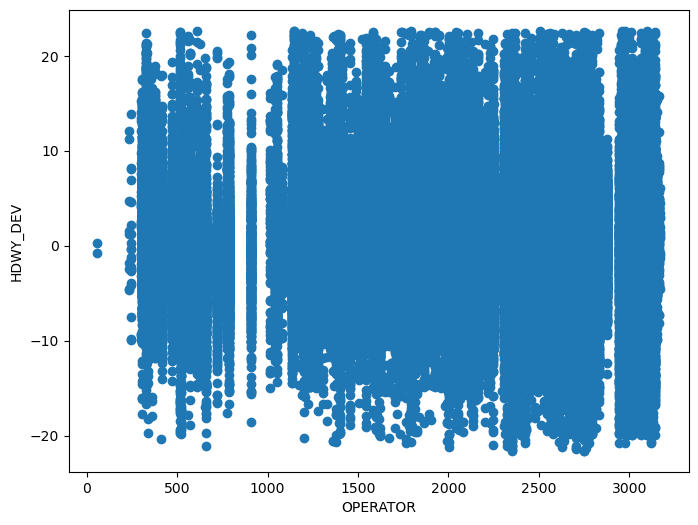

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(processed_data['OPERATOR'], processed_data['HDWY_DEV'])
plt.xlabel("OPERATOR")
plt.ylabel("HDWY_DEV")
plt.show()

**Linear regression**

In [7]:
lm = smf.ols('HDWY_DEV ~ OPERATOR', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     42.95
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:44:07   Log-Likelihood:            -7.5213e+05
No. Observations:              254299   AIC:                         1.505e+06
Df Residuals:                  253966   BIC:                         1.508e+06
Df Model:                         332                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2500      3.296     -0.076      0.940      -6.711       6.211
OPERATOR[T.235]      2.1685      3.644      0.595      0.552      -4.974       9.311
OPERATOR[T.244]      0.2125      3.457      0.061      0.951      -6.563       6.988
OPERATOR[T.301]      3.0822      3.404      0.905      0.365      -3.590       9.755
OPERATOR[T.304]      1.7516      3.298      0.531      0.595      -4.712       8.216
OPERATOR[T.326]      1.8757      3.298      0.569      0.570      -4.589       8.340
OPERATOR[T.329]     -1.7208      3.298     -0.522      0.602      -8.185       4.744
OPERATOR[T.332]      1.4489      3.298      0.439      0.660      -5.016       7.914
OPERATOR[T.341]      0.6855      3.300      0.208      0.835      -5.783       7.154
OPERATOR[T.357]      2.6641      3.299      0.808      0.419      -3.802       9.130
OPERATOR[T.359]      0.6620      3.300      0.201      0.841      -5.806       7.130
OPERATOR[T.375]      0.2183      3.611      0.060      0.952      -6.859       7.296
OPERATOR[T.379]      0.3959      3.298      0.120      0.904      -6.069       6.860
OPERATOR[T.409]      0.5389      3.298      0.163      0.870      -5.926       7.003
OPERATOR[T.414]     -0.1308      3.299     -0.040      0.968      -6.597       6.336
OPERATOR[T.465]     -1.1156      3.509     -0.318      0.751      -7.993       5.762
OPERATOR[T.471]      0.5722      3.302      0.173      0.862      -5.899       7.043
OPERATOR[T.517]     -0.5270      3.299     -0.160      0.873      -6.992       5.938
OPERATOR[T.520]     -0.4143      3.298     -0.126      0.900      -6.879       6.050
OPERATOR[T.522]     -0.6485      3.299     -0.197      0.844      -7.114       5.817
OPERATOR[T.559]      0.2411      3.298      0.073      0.942      -6.223       6.706
OPERATOR[T.572]      1.6140      3.301      0.489      0.625      -4.856       8.084
OPERATOR[T.611]     -0.4300      3.300     -0.130      0.896      -6.898       6.038
OPERATOR[T.624]     -0.5165      3.300     -0.156      0.876      -6.985       5.952
OPERATOR[T.653]      0.4533      3.322      0.136      0.891      -6.058       6.964
OPERATOR[T.659]     -1.6808      3.298     -0.510      0.610      -8.146       4.784
OPERATOR[T.723]     -1.4433      3.300     -0.437      0.662      -7.911       5.024
OPERATOR[T.778]     -0.3614      3.299     -0.110      0.913      -6.827       6.105
OPERATOR[T.785]     -0.7047      3.299     -0.214      0.831      -7.170       5.761
OPERATOR[T.907]     -0.2865      3.304     -0.087      0.931      -6.762       6.189
OPERATOR[T.1016]     1.8294      3.339      0.548      0.584      -4.716       8.375
OPERATOR[T.1040]     0.3644      3.299      0.110      0.912      -6.102       6.831
OPERATOR[T.1052]     0.0840      3.299      0.025      0.980      -6.381       6.549
OPERATOR[T.1078]     1.

In [8]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254299 entries, 0 to 254298
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   CALENDAR_ID                254299 non-null  int64   
 1   SERVICE_ABBR               254299 non-null  int64   
 2   ADHERENCE_ID               254299 non-null  int64   
 3   DATE                       254299 non-null  object  
 4   ROUTE_ABBR                 254299 non-null  int64   
 5   BLOCK_ABBR                 254299 non-null  int64   
 6   OPERATOR                   254299 non-null  category
 7   TRIP_ID                    254299 non-null  int64   
 8   OVERLOAD_ID                254299 non-null  int64   
 9   ROUTE_DIRECTION_NAME       254299 non-null  object  
 10  TIME_POINT_ABBR            254299 non-null  object  
 11  ROUTE_STOP_SEQUENCE        254299 non-null  float64 
 12  TRIP_EDGE                  254299 non-null  int64   
 13  LATITUDE      

**Question:** Which of these operators have a low p-value - aka are statistically significant? 

In [9]:
# Extracting coefficients and p-values
coefficients = lm.params
p_values = lm.pvalues

# Filtering for statistically significant coefficients (p < 0.05)
significant_coefficients = coefficients[p_values < 0.05]

# Checking if there are any significant coefficients
if not significant_coefficients.empty:
    # Creating a DataFrame for plotting
    data = pd.DataFrame({'Coefficient': significant_coefficients.values,
                         'Operator': significant_coefficients.index})

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Operator', data=data, palette='viridis')
    plt.title('Statistically Significant Coefficients')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Operator')
    plt.show()
else:
    print("No statistically significant coefficients found.")

No statistically significant coefficients found.


**Results:**

**Statistics on OPERATOR dataframe**

**Question:** Which operators are the most at following headway to the scheduled headway? 

In [27]:
# Grouping by OPERATOR and computing the mean, standard deviation, and count for HDWY_DEV and ADHERENCE
operator_stats = processed_data.groupby('OPERATOR').agg({
    'HDWY_DEV': [('mean_HDWY_DEV', 'mean'),
                 ('std_HDWY_DEV', 'std'),
                 ('count', 'count')],
    'ADHERENCE': [('mean_ADHERENCE', 'mean'),
                  ('std_ADHERENCE', 'std')]
}).reset_index()

# Rename columns 
operator_stats.columns = operator_stats.columns.droplevel(0)
operator_stats.rename(columns={'': 'OPERATOR'}, inplace=True)

operator_stats.head(10)

,OPERATOR,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
0,56,-0.250000,0.730677,2,-1.391667,2.133105
1,235,1.918518,6.305770,9,-4.198148,4.327668
2,244,-0.037500,6.095262,20,-3.509166,4.600875
3,301,2.832222,7.116150,30,-4.615555,3.629435
4,304,1.501628,3.596538,1976,-3.095015,2.985387
5,326,1.625676,5.141692,1576,-4.286294,3.480703
6,329,-1.970809,4.377375,1710,-2.475117,3.150801
7,332,1.198889,4.258641,1590,-3.171593,3.736069
8,341,0.435464,3.188792,868,-1.791820,2.849767
9,357,2.414106,5.281714,1152,-5.763614,4.700579


In [29]:
operator_stats.columns

Index(['OPERATOR', 'mean_HDWY_DEV', 'std_HDWY_DEV', 'count', 'mean_ADHERENCE',
       'std_ADHERENCE'],
      dtype='object')

In [32]:
# Sort the DataFrame by absolute values of mean_HDWY_DEV and count
sorted_operator_stats = operator_stats.assign(abs_mean_HDWY_DEV=operator_stats['mean_HDWY_DEV'].abs()) \
                                     .sort_values(by=['abs_mean_HDWY_DEV', 'count'], ascending=[True, False]) \
                                     .drop(columns=['abs_mean_HDWY_DEV'])
# Display the sorted DataFrame
sorted_operator_stats.head(10)

,OPERATOR,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
239,2623,-0.000821,4.143586,731,-2.041564,2.377932
244,2639,-0.005891,2.202460,116,-1.360776,1.517951
20,559,-0.008927,3.987104,1658,-3.381353,3.500004
213,2505,0.012752,4.735384,860,-2.355426,3.161488
123,1892,0.015889,4.156547,1072,-2.762531,3.286681
170,2253,-0.026823,3.633397,64,-2.826562,2.682001
240,2624,-0.029954,4.203299,651,-2.743651,3.319232
11,375,-0.031667,8.245756,10,-2.811666,2.582396
272,2809,0.036829,3.900808,267,-1.869039,2.375883
2,244,-0.037500,6.095262,20,-3.509166,4.600875


In [36]:
# Set the count threshold
count_threshold = 1000

# Filter operators with count at least in the thousands
filtered_operator_stats = operator_stats[operator_stats['count'] >= count_threshold]

# Sort the filtered DataFrame based on the specified criteria
sorted_filtered_operator_stats = filtered_operator_stats.sort_values(by=['mean_HDWY_DEV', 'std_HDWY_DEV', 'count'], key=lambda x: abs(x), ascending=[True, True, False])

# Select the top ten operators
top_ten_operators = sorted_filtered_operator_stats.head(10)
top_ten_operators

,OPERATOR,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
20,559,-0.008927,3.987104,1658,-3.381353,3.500004
123,1892,0.015889,4.156547,1072,-2.762531,3.286681
44,1208,-0.056822,4.159245,1522,-1.941382,2.696841
155,2127,0.064263,4.474852,1047,-2.854011,3.472174
140,2040,-0.096521,4.526691,1006,-2.144367,2.832910
119,1866,0.105605,4.416038,1011,-3.083696,2.859763
147,2088,0.106755,3.467310,1463,-2.158498,2.401397
275,2832,-0.114245,5.036913,1115,-3.535545,4.563478
31,1040,0.114391,2.749712,1040,-1.304166,1.651330
141,2041,0.117234,3.768045,1175,-2.219759,2.491379


**Goal:** Find which routes these operators drive the most

top_five_operators = [559, 1892, 1208, 2127, 2040]

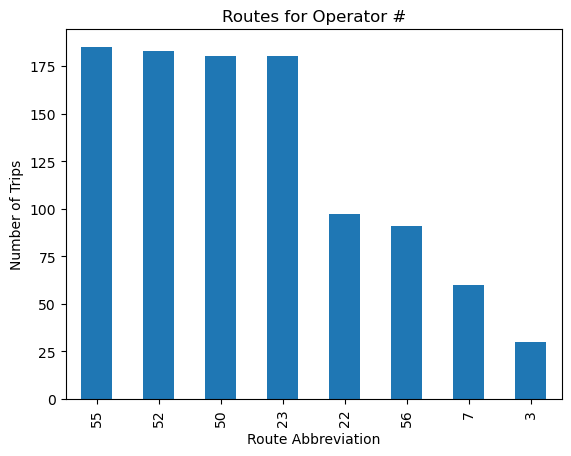

In [51]:
operatorcheck = processed_data[processed_data['OPERATOR'] == 2040]
routes_count_check = operatorcheck['ROUTE_ABBR'].value_counts()
routes_count_check.plot(kind='bar', xlabel='Route Abbreviation', ylabel='Number of Trips', title='Routes for Operator #')
plt.show()

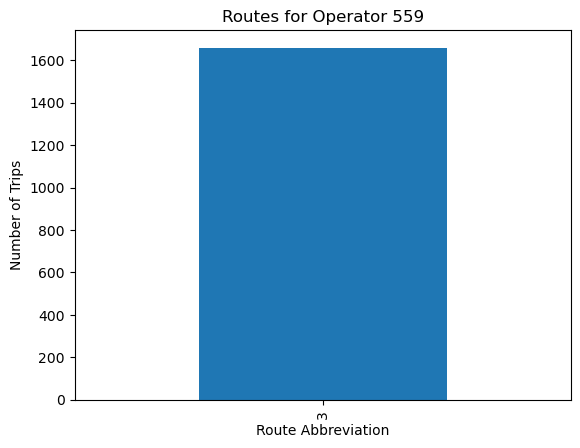

In [43]:
routes_count_check = operator559['ROUTE_ABBR'].value_counts()
routes_count_check.plot(kind='bar', xlabel='Route Abbreviation', ylabel='Number of Trips', title='Routes for Operator 559')
plt.show()

C:\Users\MJ\AppData\Local\Temp\ipykernel_20252\2821714491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_operators.loc[:, 'OPERATOR'] = top_ten_operators['OPERATOR'].astype('category')
C:\Users\MJ\AppData\Local\Temp\ipykernel_20252\2821714491.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  top_ten_operators.loc[:, 'OPERATOR'] = top_ten_operators['OPERATOR'].astype('category')


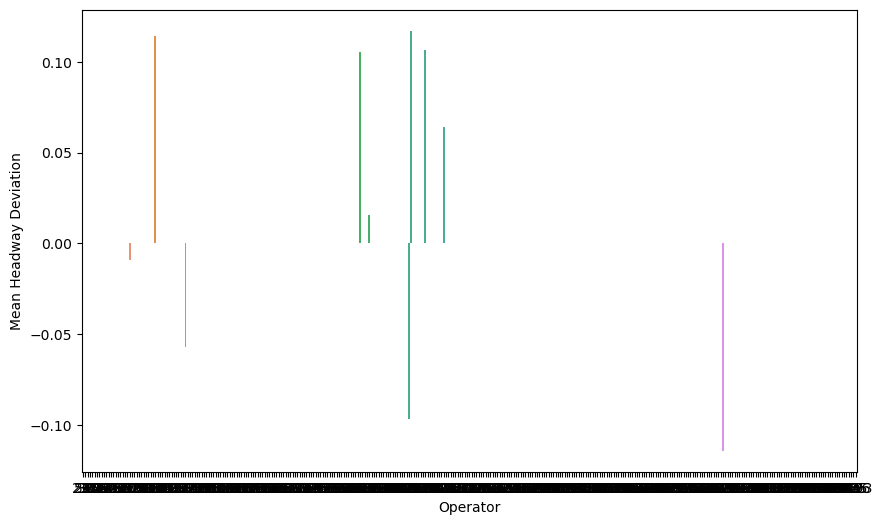

In [39]:
# Convert 'OPERATOR' to categorical
top_ten_operators.loc[:, 'OPERATOR'] = top_ten_operators['OPERATOR'].astype('category')

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='OPERATOR', y='mean_HDWY_DEV', data=top_ten_operators, errcolor='gray', capsize=0.2)
plt.ylabel('Mean Headway Deviation')
plt.xlabel('Operator')
plt.show()

**Question:** Does the operator have any impact on the NEXT_ADHERENCE based on its PREVIOUS_ADHERENCE? 

In [12]:
lm = smf.ols('NEXT_ADHERENCE ~ OPERATOR + PREVIOUS_ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         NEXT_ADHERENCE   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     418.7
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:44:21   Log-Likelihood:            -3.1563e+05
No. Observations:              130280   AIC:                         6.319e+05
Df Residuals:                  129960   BIC:                         6.350e+05
Df Model:                         319                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.8746      2.732     -0.686      0.493      -7.229       3.480
OPERATOR[T.235]       -3.1899      3.054     -1.044      0.296      -9.176       2.797
OPERATOR[T.244]       -0.2451      2.844     -0.086      0.931      -5.818       5.328
OPERATOR[T.301]        0.1607      2.807      0.057      0.954      -5.341       5.662
OPERATOR[T.304]        1.0508      2.733      0.384      0.701      -4.306       6.408
OPERATOR[T.326]        0.0618      2.734      0.023      0.982      -5.297       5.420
OPERATOR[T.329]        1.4117      2.733      0.516      0.606      -3.946       6.769
OPERATOR[T.332]        0.3991      2.733      0.146      0.884      -4.958       5.756
OPERATOR[T.341]     -6.17e-14   2.25e-13     -0.274      0.784   -5.02e-13    3.79e-13
OPERATOR[T.357]       -0.3922      2.734     -0.143      0.886      -5.751       4.967
OPERATOR[T.359]        0.7894      2.735      0.289      0.773      -4.571       6.150
OPERATOR[T.375]        0.2517      2.951      0.085      0.932      -5.532       6.035
OPERATOR[T.379]        1.1935      2.734      0.436      0.662      -4.166       6.553
OPERATOR[T.409]        0.6905      2.734      0.253      0.801      -4.667       6.048
OPERATOR[T.414]        1.1544      2.734      0.422      0.673      -4.205       6.514
OPERATOR[T.465]        4.0101      2.880      1.393      0.164      -1.634       9.654
OPERATOR[T.471]        0.6418      2.736      0.235      0.815      -4.721       6.005
OPERATOR[T.517]        0.7067      2.734      0.259      0.796      -4.651       6.065
OPERATOR[T.520]        0.6698      2.733      0.245      0.806      -4.687       6.027
OPERATOR[T.522]        1.3639      2.734      0.499      0.618      -3.994       6.722
OPERATOR[T.559]        0.7644      2.733      0.280      0.780      -4.593       6.122
OPERATOR[T.572]        0.5837      2.737      0.213      0.831      -4.780       5.947
OPERATOR[T.611]        0.5257      2.735      0.192      0.848      -4.835       5.886
OPERATOR[T.624]        0.9791      2.735      0.358      0.720      -4.381       6.340
OPERATOR[T.653]        1.8120      2.751      0.659      0.510      -3.580       7.204
OPERATOR[T.659]        1.6756      2.733      0.613      0.540      -3.682       7.033
OPERATOR[T.723]    -1.295e-13   4.95e-13     -0.261      0.794    -1.1e-12    8.41e-13
OPERATOR[T.778]        1.0046      2.734      0.367      0.713      -4.354       6.364
OPERATOR[T.785]        1.2047      2.734      0.441      0.659      -4.154       6.563
OPERATOR[T.907]        0.9836      2.738      0.359      0.719      -4.383       6.350
OPERATOR[T.1016]       0.1580      2.758      0.057      0.954      -5.248       5.564
OPERATOR[T.1040]       1.4691      2.742      0.536      0.592      -3.905       6.843
OPERATOR[T.1052]       0.9140      2.7

**Results:**
- R-squared of 0.492: this model explains about 49.2% of the variance in NEXT_ADHERENCE. 
- With a large F-statistic and a very low F-statistic p-value, this means this model is statistically significant. 
- The p-values associated with the t-statistics are very low (close to 0), which means that they're statistically significant. 

mean(NEXT_ADHERENCE) = -0.7095(NEXT_ADHERENCE) - .0001(OPERATOR) + .7451(PREVIOUS_ADHERENCE)
- For every unit change in PREVIOUS_ADHERENCE, NEXT_ADHERENCE is supposed to increase by .7451 units. With the OPERATOR being so close to zero, this means that it has no impact on NEXT_ADHERENCE. 

**Question:** How does days of the week affect headway deviation or adherence? 

In [13]:
# Convert the DATE column to a datetime data type 
processed_data['DATE'] = pd.to_datetime(processed_data['DATE'])

# Create a new column to store the day of the week 
processed_data['Day_of_Week'] = processed_data['DATE'].dt.dayofweek + 1 
processed_data['Day_Type'] = processed_data['Day_of_Week'].apply(lambda x: 'Weekday' if 1 <= x <= 5 else 'Weekend')

processed_data.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE,Day_of_Week,Day_Type
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,80,0.000000,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666,2,Weekday
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,70,0.000000,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666,2,Weekday
2,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,63,13.216666,0.076190,0.300000,0.274867,120230801_345106,-1.916666,NaN,2,Weekday
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,97,10.800000,-0.144444,-0.374878,0.336403,120230801_345107,NaN,1.500000,2,Weekday
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,112,0.000000,-0.258889,-0.614577,0.769723,120230801_345107,-1.316666,NaN,2,Weekday


In [14]:
processed_data.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PERC', 'Z_HDWY_DEV', 'Z_ADHERENCE',
       'UNIQUE_TRIP_ID', 'PREVIOUS_ADHERENCE', 'NEXT_ADHERENCE', 'Day_of_Week',
       'Day_Type'],
      dtype='object')

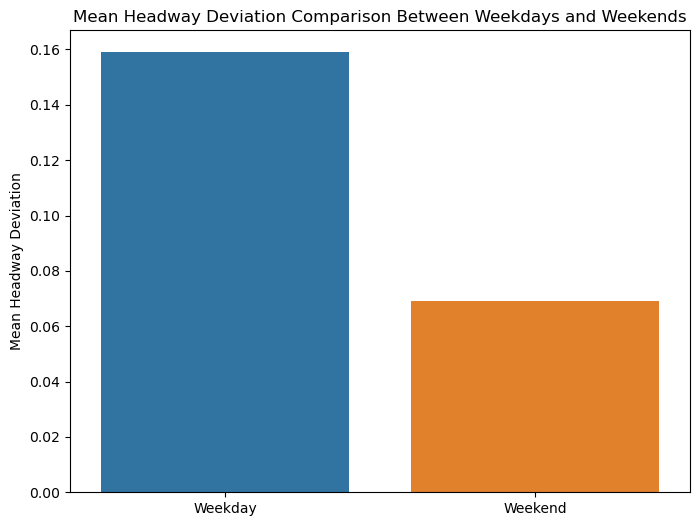

In [15]:
# Filter data for weekdays and weekends
weekday_data = processed_data[processed_data['Day_Type'] == 'Weekday']
weekend_data = processed_data[processed_data['Day_Type'] == 'Weekend']

# Set up the data for plotting
data_to_plot = [weekday_data['HDWY_DEV'], weekend_data['HDWY_DEV']]

# Create a bar plot with error bars
plt.figure(figsize=(8, 6))
sns.barplot(x=['Weekday', 'Weekend'], y=[data.mean() for data in data_to_plot], errcolor='gray', capsize=0.2)
plt.ylabel('Mean Headway Deviation')
plt.title('Mean Headway Deviation Comparison Between Weekdays and Weekends')

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/mean_hdwy_dev_comparison_types_of_day.png');
plt.show()

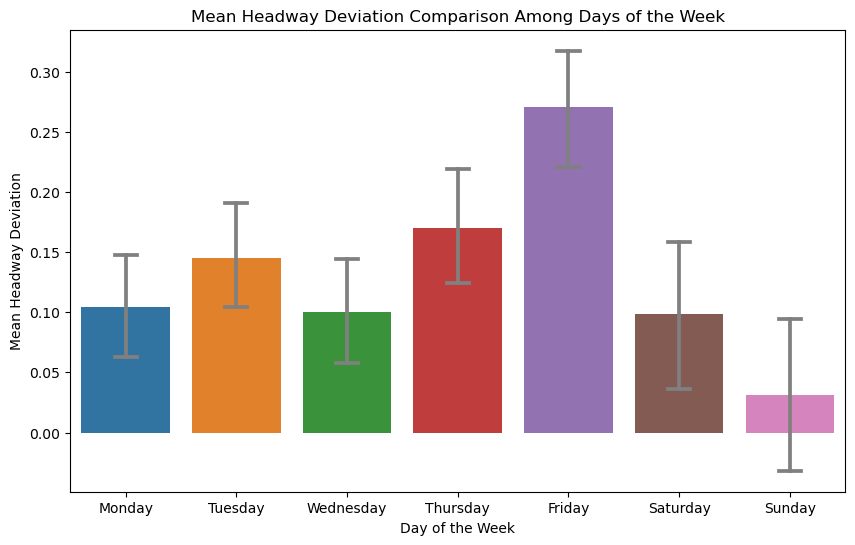

In [16]:
# Create a bar plot with error bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='HDWY_DEV', data=processed_data, errcolor='gray', capsize=0.2)
plt.ylabel('Mean Headway Deviation')
plt.xlabel('Day of the Week')
plt.title('Mean Headway Deviation Comparison Among Days of the Week')
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Dictionary for custom x tick labels 
day_order = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

# Set custom x-axis labels
custom_labels = [day_order[i] for i in range(1, 8)]
plt.xticks(range(7), custom_labels)

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/images/mean_hdwy_dev_comparison.png');
plt.show();

**Question:** Are there specific days that have a wide range of deviation from headway? 

In [17]:
# Encode 'Day_Type' as a categorical variable
processed_data['Day_Type'] = processed_data['Day_Type'].astype('category')

# Create dummy variables for 'Day_Type' (one-hot encoding)
day_type_dummies = pd.get_dummies(processed_data['Day_Type'], prefix='Day_Type')

# Add the dummy variables to the DataFrame
processed_data = pd.concat([processed_data, day_type_dummies], axis=1)

In [18]:
lm = smf.ols('HDWY_DEV ~ Day_Type_Weekday + Day_Type_Weekend', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.70
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           0.000214
Time:                        11:44:27   Log-Likelihood:            -7.5907e+05
No. Observations:              254299   AIC:                         1.518e+06
Df Residuals:                  254297   BIC:                         1.518e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0760      0.008      9.373      0.000       0.060       0.092
Day_Type_Weekday     0.0830      0.010      8.191      0.000       0.063       0.103
Day_Type_Weekend    -0.0070      0.015     -0.467      0.640      -0.036       0.022
==============================================================================
Omnibus:                    19977.617   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70186.392
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       5.470   Cond. No.                     5.05e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.73e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Interpretation:**

- The model does not explain much of the variance in 'HDWY_DEV' as indicated by the low R-squared value.
- The **'Day_Type_Weekday' coefficient is statistically significant (p-value is 0.000),** suggesting that 'Day_Type' has an influence on 'HDWY_DEV' on weekdays.
- The 'Day_Type_Weekend' coefficient is not statistically significant (p-value is 0.640), suggesting that 'Day_Type' does not have a statistically significant influence on 'HDWY_DEV' on weekends.
- The presence of significant multicollinearity issues is indicated by the small eigenvalue.

In [19]:
lm = smf.ols('HDWY_DEV ~ Day_of_Week', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1545
Date:                Tue, 14 Nov 2023   Prob (F-statistic):              0.694
Time:                        11:44:28   Log-Likelihood:            -7.5907e+05
No. Observations:              254299   AIC:                         1.518e+06
Df Residuals:                  254297   BIC:                         1.518e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1346      0.021      6.329      0.000       0.093       0.176
Day_of_Week     0.0020      0.005      0.393      0.694      -0.008       0.012
==============================================================================
Omnibus:                    19983.271   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70349.799
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       5.473   Cond. No.                         9.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation:** 

The results suggest that the "Day_of_Week" variable does not have a significant impact on explaining the variation in "HDWY_DEV." The model is not a good fit for the data, and there is no evidence to support a strong relationship between the day of the week and headway deviation based on this analysis.

C:\Users\MJ\AppData\Local\Temp\ipykernel_20252\2633960425.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Day_of_Week', y='HDWY_DEV', data=processed_data, palette='viridis', alpha=0.7)


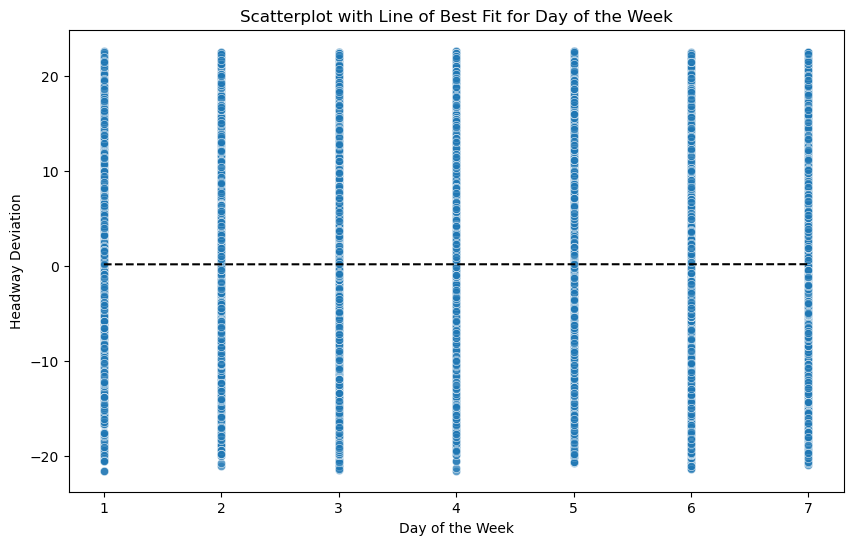

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Day_of_Week', y='HDWY_DEV', data=processed_data, palette='viridis', alpha=0.7)

# Fit a line of best fit for the entire dataset
model = sm.OLS(processed_data['HDWY_DEV'], sm.add_constant(processed_data['Day_of_Week'])).fit()

# Generate x values for the line
x_values = np.linspace(processed_data['Day_of_Week'].min(), processed_data['Day_of_Week'].max(), 100)

# Calculate y values based on the regression model
y_values = model.predict(sm.add_constant(x_values))

# Plot the line of best fit with black color
plt.plot(x_values, y_values, linestyle='--', color='black')

plt.xlabel('Day of the Week')
plt.ylabel('Headway Deviation')
plt.title('Scatterplot with Line of Best Fit for Day of the Week')
plt.show()

In [21]:
bna_weather = pd.read_csv("../data/bna_weather.csv")
bna_weather.head(4)

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT08
0,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-01,6.49,NaN,0.00,0.0,0.0,80,89,70,50,10,13.0,21.0,NaN,NaN,NaN,NaN
1,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-02,2.91,NaN,0.00,0.0,0.0,77,86,65,150,180,8.1,12.1,NaN,NaN,NaN,NaN
2,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-03,4.92,NaN,1.19,0.0,0.0,77,81,72,230,300,12.1,29.1,1.0,NaN,1.0,NaN
3,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-04,2.24,NaN,0.12,0.0,0.0,78,84,73,270,40,8.9,14.1,1.0,NaN,NaN,NaN


In [22]:
Transit_Bus_Stops = pd.read_csv("../data/WeGo_Transit_Bus_Stops_20231025.csv")
Transit_Bus_Stops.head(4)

,Stop ID,Stop Abbreviation,Stop Name,Shelter?,Bench?,Route Numbers,Route Name,Mapped Location
0,5120,7AVUNINN,7TH AVE & UNION ST NB,False,False,NaN,AIRPORT - DOWNTOWN HOTELS,NaN
1,5455,CM5_4,Temporary Bay 4,False,False,NaN,HERMAN,NaN
2,2762,23ACLASF,23RD AVE N & CLARKSVILLE PIKE SB,False,False,22,BORDEAUX,NaN
3,4079,21ACHUSN,21ST AVE N & CHURCH ST SB,False,True,25,MIDTOWN,NaN


**Question:** How does times of day and day impact headway deviation? 